# 2023-02-27
## Weight initialization and batch norm

In [6]:
import torch
import requests
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

from typing import List, Tuple, Dict, Callable, Optional, Union

from sklearn.model_selection import train_test_split

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# read in all the words
words = requests.get("https://raw.githubusercontent.com/karpathy/makemore/master/names.txt").text.splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
block_size = 3

def build_dataset(words: List[str], block_size: int = 3) -> Tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [10]:
train_data, test_data = train_test_split(words, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

Xtr, Ytr = build_dataset(train_data, block_size)
Xte, Yte = build_dataset(test_data, block_size)
Xdev, Ydev = build_dataset(val_data, block_size)

In [11]:
Xtr.shape, Xte.shape, Xdev.shape

(torch.Size([182497, 3]), torch.Size([22882, 3]), torch.Size([22767, 3]))

In [34]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
# LAYER ONE ----
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
# LAYER TWO ----
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [35]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # SAMPLE A BATCH
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # FORWARD PASS
    emb = C[Xb] # <- Drawing embeddings from C
    embcat = emb.view(-1, n_embd * block_size) # <- Concatenating the embeddings
    hprect = embcat @ W1 + b1 # <- Linear layer
    h = torch.tanh(hprect) # <- Nonlinearity
    logits = h @ W2 + b2 # <- Linear layer
    loss = F.cross_entropy(logits, Yb) # <- Cross entropy loss

    # Cross entropy loss is defined as:
    # loss = -log(softmax(logits)[Yb])
    # softmax is defined as: exp(logits) / sum(exp(logits))

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % 10000 == 0:
        print(i, loss.item())
    lossi.append(loss.item())


0 27.88172721862793
10000 2.8263330459594727
20000 2.512991428375244
30000 2.8009753227233887
40000 2.0540659427642822
50000 2.615243434906006
60000 2.3549277782440186
70000 2.083524703979492
80000 2.2651586532592773
90000 2.263528823852539
100000 2.0809543132781982
110000 2.3367362022399902
120000 1.964974284172058
130000 2.439828395843506
140000 2.152369499206543
150000 2.120079517364502
160000 2.0398831367492676
170000 1.8172087669372559
180000 2.0771164894104004
190000 1.7632445096969604


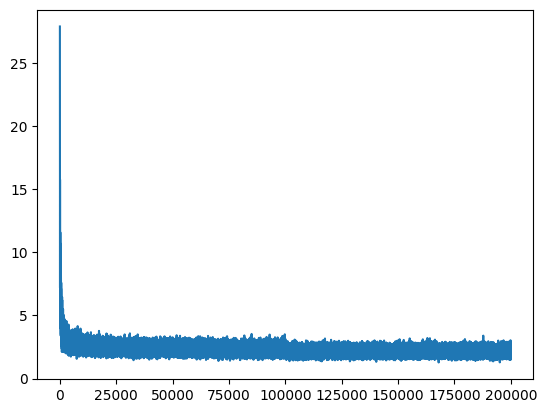

In [36]:
plt.plot(lossi)

In [91]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "test": (Xte, Yte),
        "dev": (Xdev, Ydev),
    }[split]

    emb = C[x]
    embcat = emb.view(-1, n_embd * block_size)
    hprect = embcat @ W1 + b1
    h = torch.tanh(hprect)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.3f}")

split_loss("dev")
split_loss("test")

dev loss: 2.169
test loss: 2.162


In [92]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carlah.
amorie.
khi.
myli.
taty.
salayson.
mahnen.
den.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearynix.
kaelissuli.


In [94]:
-torch.tensor(1/27).log()

tensor(3.2958)

In [98]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -torch.log(probs[2])
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [100]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -torch.log(probs[2])
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [101]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -torch.log(probs[3])
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(5.0200))

In [102]:
logits = torch.tensor([-3.0, 0.0, 0.0, 5.0])
probs = F.softmax(logits, dim=0)
loss = -torch.log(probs[2])
probs, loss

(tensor([3.3089e-04, 6.6462e-03, 6.6462e-03, 9.8638e-01]), tensor(5.0137))

In [105]:
logits = torch.randn(4) * 10
probs = F.softmax(logits, dim=0)
loss = -torch.log(probs[2])
logits, probs, loss

(tensor([-9.8732, -5.6832, 11.2269, -1.1781]),
 tensor([6.8608e-10, 4.5296e-08, 1.0000e+00, 4.0982e-06]),
 tensor(4.0531e-06))

In [106]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(-1, n_embd * block_size)
    hprect = embcat @ W1 + b1
    h = torch.tanh(hprect)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    if i % 10000 == 0:
        print(i, loss.item())
    lossi.append(loss.item())
    break


11897
0 27.88172721862793


In [107]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [109]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
  # minibatch construct
  ix = torch. randint (0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  # forwyrd pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape [0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += - lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss. item():.4f}')
  lossi.append(loss.log10().item())

  break

11897
      0 / 200000: 4.2326


In [110]:
logits[0]

tensor([-0.2490,  3.5232, -1.2675,  0.5407,  1.6622, -1.1708, -0.1398,  0.1242,
         0.9210,  1.1347,  1.3624, -0.9252,  0.4438, -2.4594, -0.9714,  0.1247,
        -0.9572, -1.3763, -2.3287, -0.1374,  2.4522,  1.6165,  1.6649, -1.0944,
        -2.1544,  0.7255,  1.1413], grad_fn=<SelectBackward0>)

In [111]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

In [112]:
h.shape

torch.Size([32, 200])

In [133]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range (max_steps):
  # minibatch construct
  ix = torch. randint (0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  # forwyrd pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape [0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += - lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss. item():.4f}')
  lossi.append(loss.log10().item())

11897
      0 /  20000: 4.2326
  10000 /  20000: 2.1403


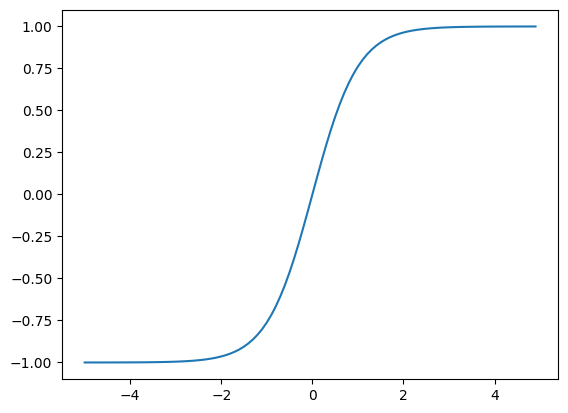

In [134]:
plt.plot(torch.arange(-5, 5, 0.1).tolist(), torch.tanh(torch.arange(-5, 5, 0.1)).tolist())

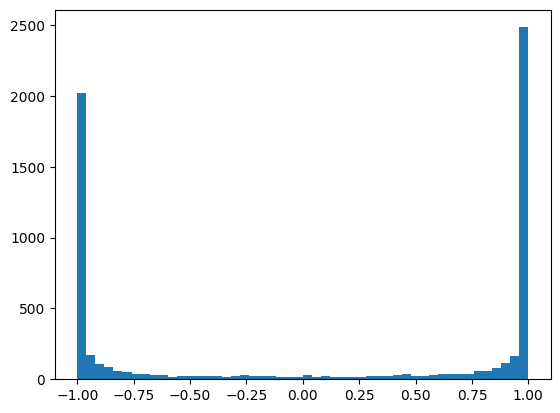

In [135]:
plt.hist(h.view(-1).tolist(), 50);

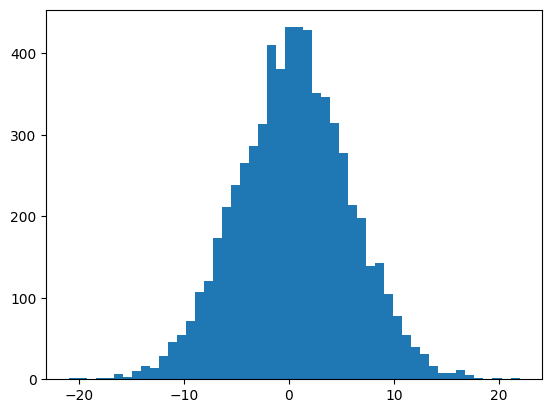

In [136]:
plt.hist(hpreact.view(-1).tolist(), 50);

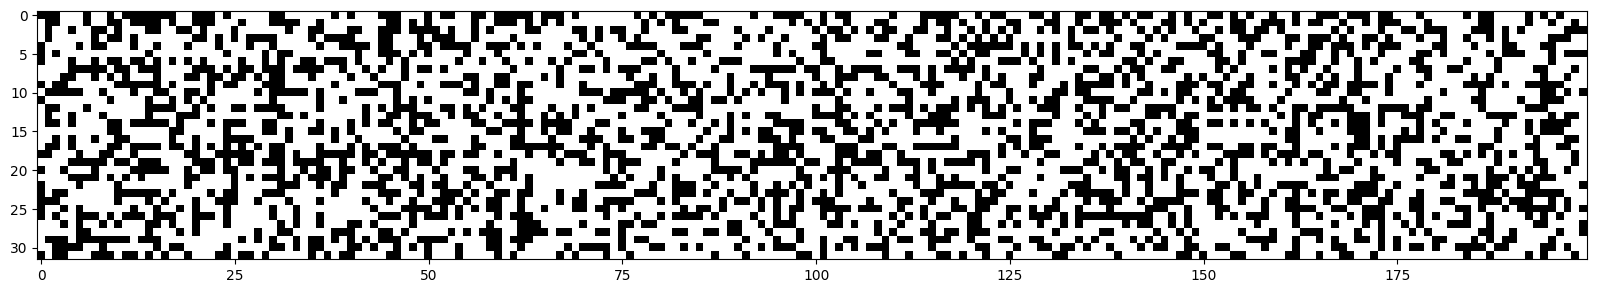

In [137]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

```python
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self._grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
```

in backprop if the t was close to 1, we are outputing 0, thus killing the gradient

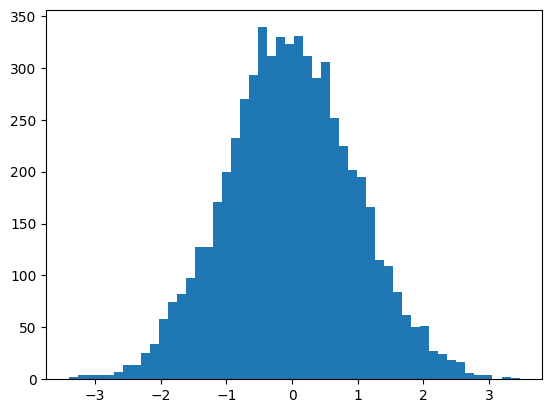

In [138]:
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)

plt.hist(W1.view(-1).tolist(), 50);

![](https://camo.githubusercontent.com/184fce8bb465253a92b621ddd27f7926a4bb693990a61aef5fdde8750d947f0e/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313230302f312a5a616644763356556d3630456831304f654a753176772e706e67)

In [158]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.2
b2 = torch.randn(vocab_size, generator=g) * 0.2
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range (max_steps):
  # minibatch construct
  ix = torch. randint (0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  # forwyrd pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape [0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += - lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss. item():.4f}')
  lossi.append(loss.log10().item())
  break

11897
      0 /  20000: 3.2966


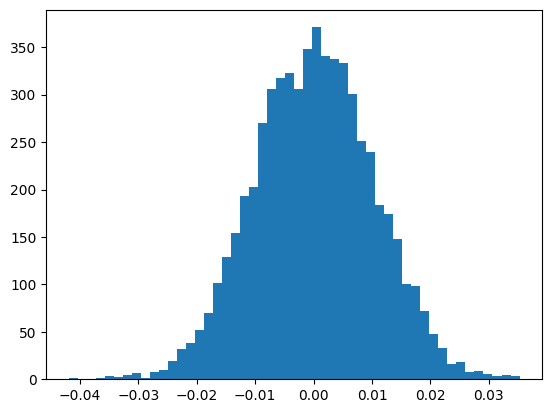

In [159]:
plt.hist(W1.view(-1).tolist(), 50);

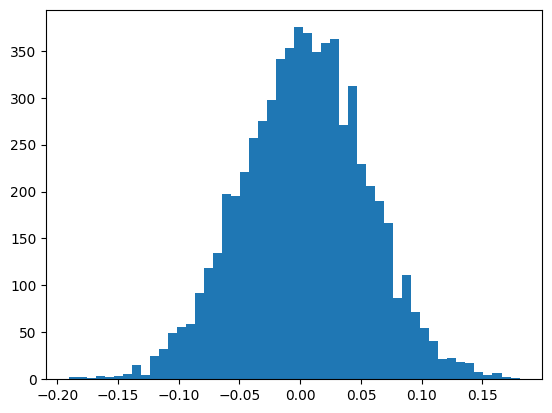

In [160]:
plt.hist(hpreact.view(-1).tolist(), 50);

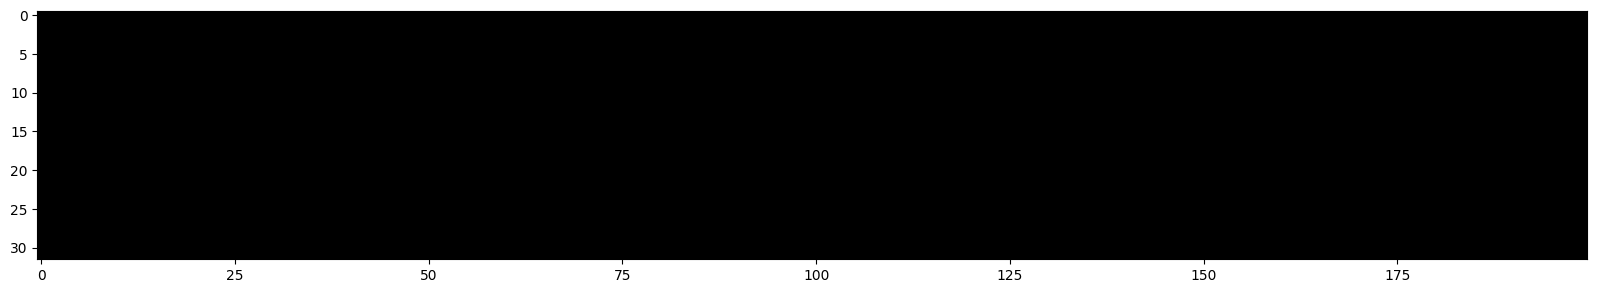

In [161]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest");

In [162]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.2
b2 = torch.randn(vocab_size, generator=g) * 0.2
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
  # minibatch construct
  ix = torch. randint (0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  # forwyrd pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape [0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += - lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss. item():.4f}')
  lossi.append(loss.log10().item())

11897
      0 / 200000: 4.9456
  10000 / 200000: 2.1332
  20000 / 200000: 2.3202
  30000 / 200000: 2.4190
  40000 / 200000: 1.9748
  50000 / 200000: 2.3811
  60000 / 200000: 2.4136
  70000 / 200000: 2.1318
  80000 / 200000: 2.2612
  90000 / 200000: 2.1730
 100000 / 200000: 1.9046
 110000 / 200000: 2.1883
 120000 / 200000: 1.8553
 130000 / 200000: 2.3637
 140000 / 200000: 2.2713
 150000 / 200000: 2.1134
 160000 / 200000: 1.7774
 170000 / 200000: 1.8484
 180000 / 200000: 1.8993
 190000 / 200000: 1.9216


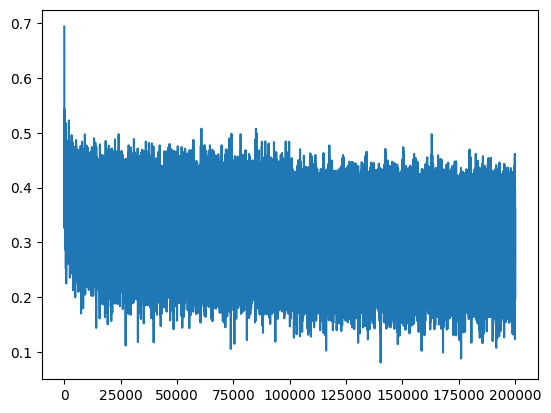

In [163]:
plt.plot(lossi)

In [164]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss("train")
split_loss("dev")

train loss: 2.0372
dev loss: 2.1028


In [178]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 1e-8
b1 = torch.randn(n_hidden, generator=g) * 1e-8
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 1e-8
b2 = torch.randn(vocab_size, generator=g) * 1e-8
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
  # minibatch construct
  ix = torch. randint (0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  # forwyrd pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape [0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += - lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss. item():.4f}')
  lossi.append(loss.log10().item())
  break

11897
      0 / 200000: 3.2958


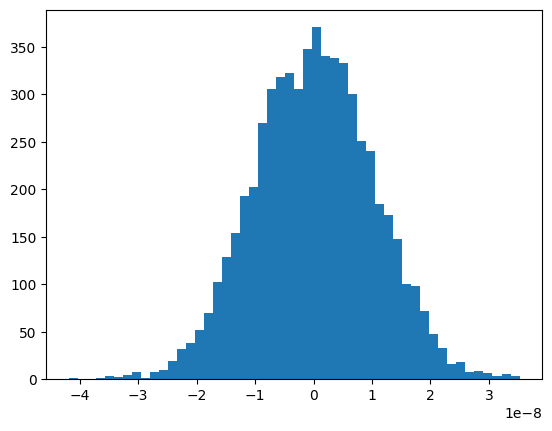

In [179]:
plt.hist(W1.view(-1).tolist(), 50);

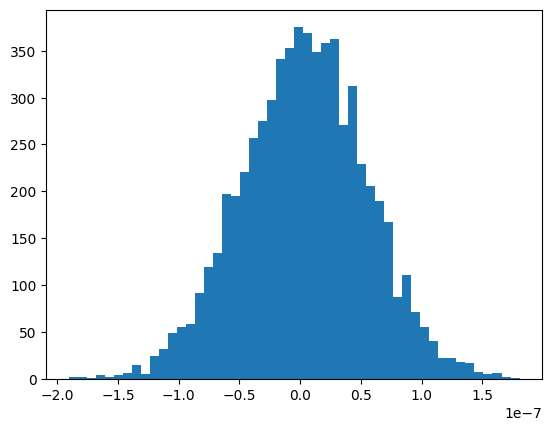

In [180]:
plt.hist(hpreact.view(-1).tolist(), 50);

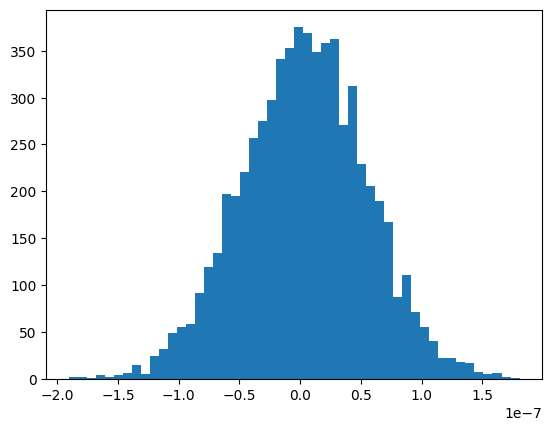

In [181]:
plt.hist(h.view(-1).tolist(), 50);

tensor(0.0180) tensor(0.9953)
tensor(0.0002) tensor(3.1546)


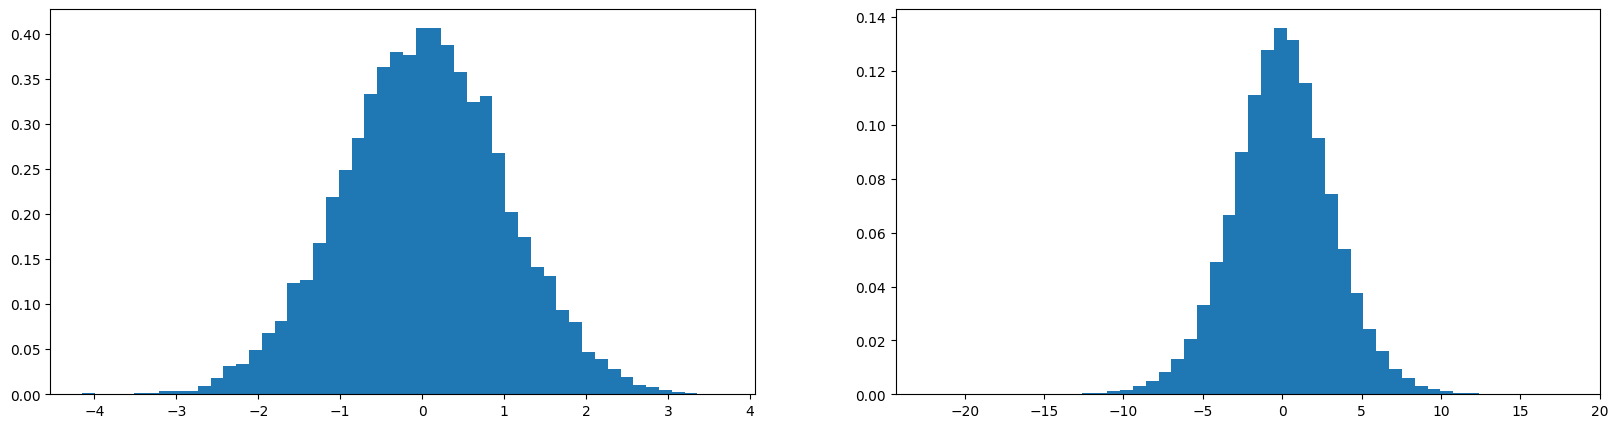

In [183]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(0.0034) tensor(1.0056)
tensor(0.0265) tensor(31.8926)


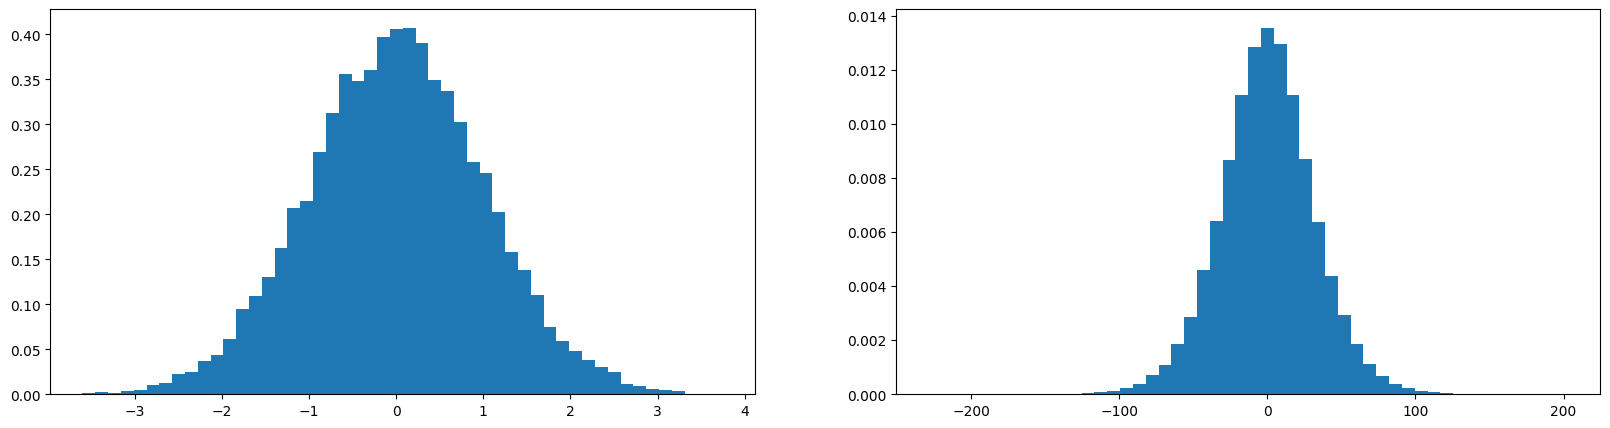

In [184]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 10
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(-0.0080) tensor(1.0072)
tensor(-6.3738e-07) tensor(0.0003)


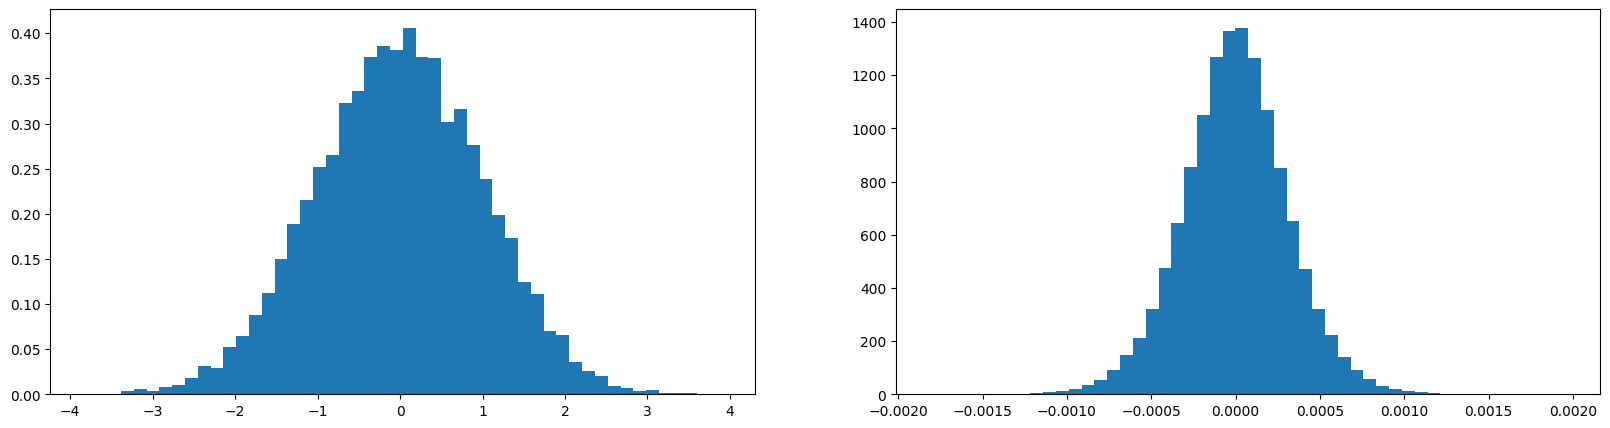

In [185]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.0001
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(0.0011) tensor(0.9978)
tensor(-0.0006) tensor(0.3175)


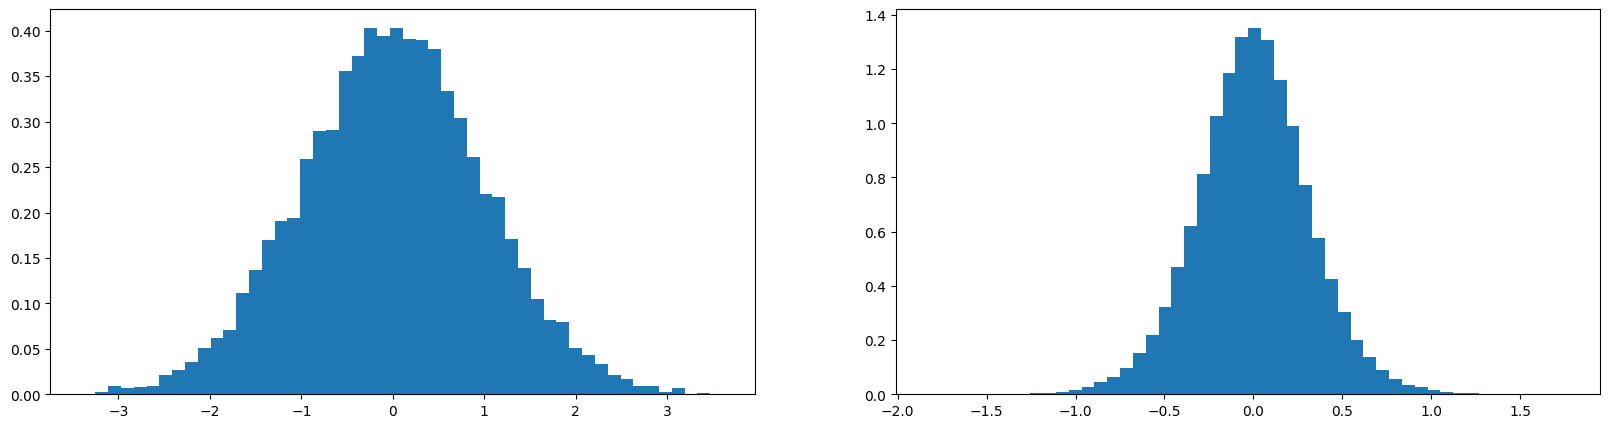

In [186]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.1
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(0.0147) tensor(1.0040)
tensor(-0.0004) tensor(1.0192)


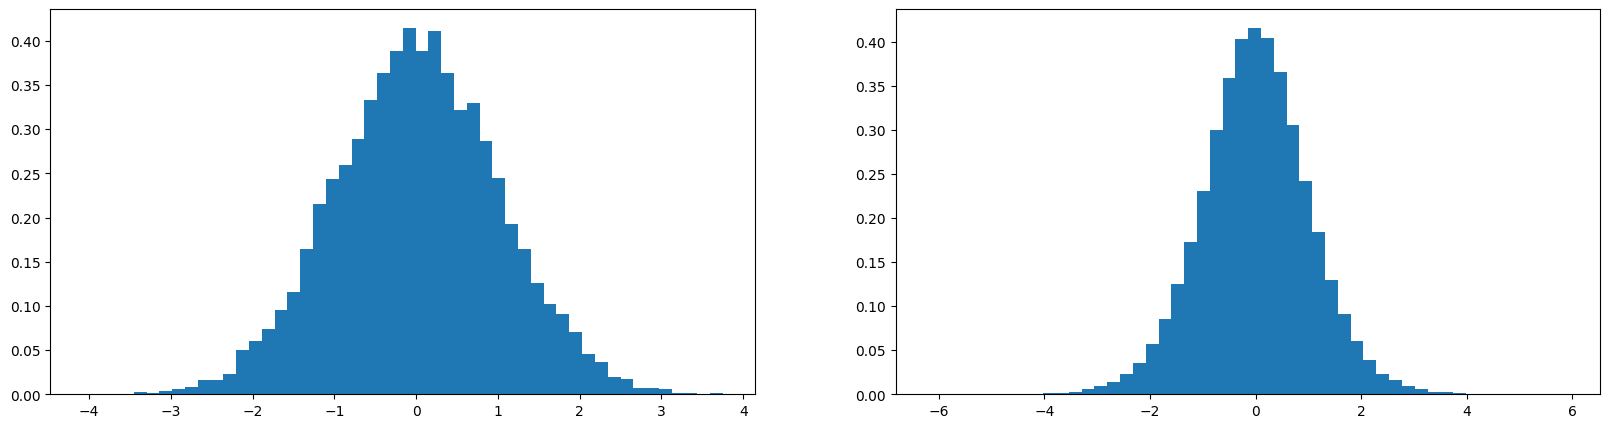

In [188]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
n_embd 

In [193]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
  # minibatch construct
  ix = torch. randint (0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  # forwyrd pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape [0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += - lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss. item():.4f}')
  lossi.append(loss.log10().item())

11897
      0 / 200000: 3.3174
  10000 / 200000: 2.1913
  20000 / 200000: 2.3277
  30000 / 200000: 2.5396
  40000 / 200000: 1.9471
  50000 / 200000: 2.3337
  60000 / 200000: 2.3857
  70000 / 200000: 2.1183
  80000 / 200000: 2.3167
  90000 / 200000: 2.1966
 100000 / 200000: 1.8569
 110000 / 200000: 2.0908
 120000 / 200000: 1.9348
 130000 / 200000: 2.3935
 140000 / 200000: 2.0937
 150000 / 200000: 2.1437
 160000 / 200000: 1.7854
 170000 / 200000: 1.7258
 180000 / 200000: 1.9731
 190000 / 200000: 1.8616


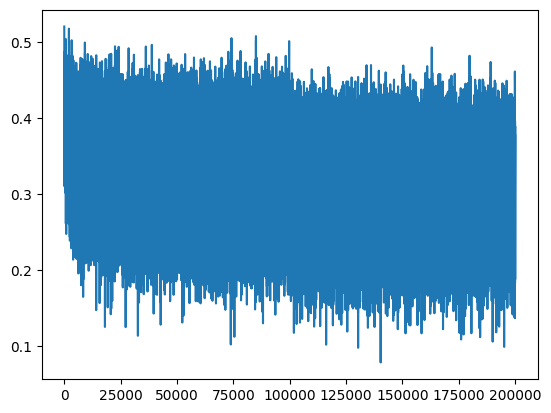

In [194]:
plt.plot(lossi)

In [195]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss("train")
split_loss("test")
split_loss("dev")

train loss: 2.0376
test loss: 2.1049
dev loss: 2.1068


In [196]:
hpreact.shape

torch.Size([32, 200])

In [200]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [201]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [206]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
  # minibatch construct
  ix = torch. randint (0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  # forwyrd pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape [0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

  hpreact = bngain * (hpreact - bnmean) / (bnstd + 1e-5) + bnbias

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += - lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss. item():.4f}')
  lossi.append(loss.log10().item())

12297
      0 / 200000: 3.3142
  10000 / 200000: 2.1983
  20000 / 200000: 2.3373
  30000 / 200000: 2.4363
  40000 / 200000: 2.0120
  50000 / 200000: 2.2591
  60000 / 200000: 2.4776
  70000 / 200000: 2.1007
  80000 / 200000: 2.2789
  90000 / 200000: 2.1857
 100000 / 200000: 1.9473
 110000 / 200000: 2.2995
 120000 / 200000: 1.9838
 130000 / 200000: 2.4511
 140000 / 200000: 2.3840
 150000 / 200000: 2.1984
 160000 / 200000: 1.9732
 170000 / 200000: 1.8664
 180000 / 200000: 1.9974
 190000 / 200000: 1.8343


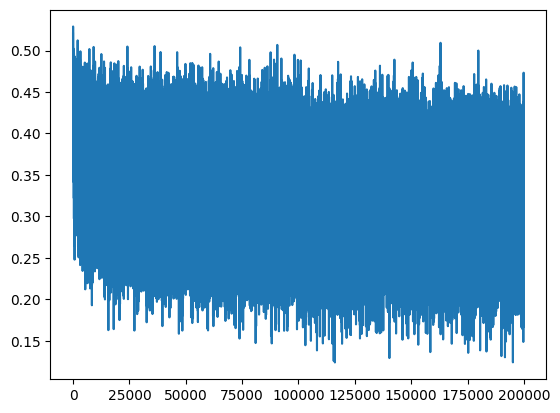

In [207]:
plt.plot(lossi)

In [209]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmen = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [219]:
with torch.no_grad():
    print(bnstd.mean(), bnstd_running.mean())

tensor(2.0287) tensor(2.1449)


In [212]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss("train")
split_loss("test")
split_loss("dev")

train loss: 2.0887
test loss: 2.1256
dev loss: 2.1271


In [12]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01 <-- NO need to use it anymore
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

#parameters = [C, W1, W2, b1, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

print(sum(p.nelement () for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
  # minibatch construct
  ix = torch. randint (0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  # forwyrd pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape [0], -1) # concatenate the vectors
  #hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = embcat @ W1 # hidden layer pre-activation without bias

  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

  hpreact = bngain * (hpreact - bnmean) / (bnstd + 1e-5) + bnbias

  with torch.no_grad():
    bnmean_running = bnmean_running * 0.9 + bnmean * 0.1
    bnstd_running = bnstd_running * 0.9 + bnstd * 0.1

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += - lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss. item():.4f}')
  lossi.append(loss.log10().item())

12297
      0 / 200000: 3.2995
  10000 / 200000: 2.3713
  20000 / 200000: 2.1576
  30000 / 200000: 2.0827
  40000 / 200000: 2.3178
  50000 / 200000: 2.2151
  60000 / 200000: 2.0033
  70000 / 200000: 2.5885
  80000 / 200000: 1.8695
  90000 / 200000: 2.3432
 100000 / 200000: 2.3691
 110000 / 200000: 1.8725
 120000 / 200000: 1.7846
 130000 / 200000: 2.2767
 140000 / 200000: 2.0475
 150000 / 200000: 2.1357
 160000 / 200000: 1.9667
 170000 / 200000: 2.3371
 180000 / 200000: 2.0856
 190000 / 200000: 1.9302


In [14]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss("train")
split_loss("test")
split_loss("dev")

train loss: 2.0653
test loss: 2.1079
dev loss: 2.1206


In [47]:
class Module:
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError
    
    def parameters(self) -> List[Optional[torch.Tensor]]:
        raise NotImplementedError

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

class Embedding(Module):
    def __init__(self, vocab_size: int, emb_size: int) -> None:
        self._weight = torch.randn((vocab_size, emb_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.out = self._weight[x]
        return self.out

    def parameters(self) -> List[Optional[torch.Tensor]]:
        return [self._weight]

class Linear(Module):
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self._weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self._bias: Optional[torch.Tensor] = torch.randn(fan_out) if bias else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self._weight + (self._bias if self._bias is not None else 0)
        return self.out

    def parameters(self) -> List[Optional[torch.Tensor]]:
        return [self._weight, self._bias] if self._bias is not None else [self._weight]
    
class Tanh(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> List[Optional[torch.Tensor]]:
        return []
    
class BatchNorm1d(Module):
    def __init__(self, fan_in: int, eps: float = 1e-5, momentum: float = 1e-1) -> None:
        self._gamma = torch.ones((1, fan_in))
        self._beta = torch.zeros((1, fan_in))

        self._momentum = momentum
        self._eps = eps

        self._training: bool = True
    
        self._mean_running = torch.zeros((1, fan_in))
        self._var_running = torch.ones((1, fan_in))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self._training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)

            with torch.no_grad():
                self._mean_running = self._mean_running * (1 - self._momentum) + xmean * self._momentum
                self._var_running = self._var_running * (1 - self._momentum) + xvar * self._momentum
        else:
            xmean = self._mean_running
            xvar = self._var_running
        
        xhat = (x - xmean) / torch.sqrt(xvar + self._eps)
        self.out = self._gamma * xhat + self._beta

        return self.out
    
    def parameters(self) -> List[Optional[torch.Tensor]]:
        return [self._gamma, self._beta]


class Sequential(Module):
    def __init__(self, *modules: Module) -> None:
        self._modules = modules
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for module in self._modules:
            x = module(x)
        return x
    
    def parameters(self) -> List[Optional[torch.Tensor]]:
        return [p for module in self._modules for p in module.parameters()]


In [23]:
tanh = Tanh()

tanh(torch.tensor([1,2,3]))

tensor([0.7616, 0.9640, 0.9951])

In [27]:
linear = Linear(3, 4)

linear(torch.tensor([1,2,3], dtype=torch.float32))

print(linear.parameters())

[tensor([[ 0.5521,  0.3668, -0.1454,  0.7035],
        [-0.0148, -0.4435,  0.2107,  0.2440],
        [-0.3799, -0.1831,  0.4219,  0.0916]]), tensor([ 0.6375, -0.4111,  0.5582, -0.3342])]


In [28]:
linear = Linear(3, 4, bias=False)

linear(torch.tensor([1,2,3], dtype=torch.float32))

print(linear.parameters())

[tensor([[-0.2012,  0.2588, -0.4186,  0.4168],
        [-0.1386,  0.0155,  0.1002,  0.0313],
        [-0.5672,  0.4625, -0.0639, -0.5213]])]


In [38]:
batch_norm = BatchNorm1d(4)

batch_norm(torch.tensor([[1,2,3,4], [5,6,7,8]], dtype=torch.float32))

print(batch_norm.parameters())

[tensor([[1., 1., 1., 1.]]), tensor([[0., 0., 0., 0.]])]


In [45]:
network = Sequential(
    Linear(3, 4),
    Tanh(),
    Linear(4, 5),
    Tanh(),
    Linear(5, 2),
)

In [46]:
network(torch.tensor([1,2,3], dtype=torch.float32))

tensor([1.0155, 0.3182])

In [61]:
n_embd = 10
n_hidden = 100

network = Sequential(
    Embedding(vocab_size, n_embd),
    Linear(n_embd * block_size, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
)

In [62]:
print(sum(p.nelement() for p in network.parameters()))

6097


47024


In [63]:
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=True), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), Tanh(),
  Linear(           n_hidden, vocab_size, bias=True),
]

with torch.no_grad():
    layers[-1]._weight *= 0.1
  
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
          layer._weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True     

46497


In [160]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False),  Tanh(), BatchNorm1d(n_hidden),
  Linear(           n_hidden, n_hidden, bias=False),  Tanh(), BatchNorm1d(n_hidden),
  Linear(           n_hidden, n_hidden, bias=False),  Tanh(), BatchNorm1d(n_hidden),
  Linear(           n_hidden, n_hidden, bias=False),  Tanh(), BatchNorm1d(n_hidden),
  Linear(           n_hidden, n_hidden, bias=False),  Tanh(), BatchNorm1d(n_hidden),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [161]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3113


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 22.09%
layer 4 (      Tanh): mean -0.00, std 0.78, saturated: 22.91%
layer 7 (      Tanh): mean +0.01, std 0.78, saturated: 24.22%
layer 10 (      Tanh): mean -0.00, std 0.79, saturated: 24.94%
layer 13 (      Tanh): mean +0.01, std 0.78, saturated: 24.44%


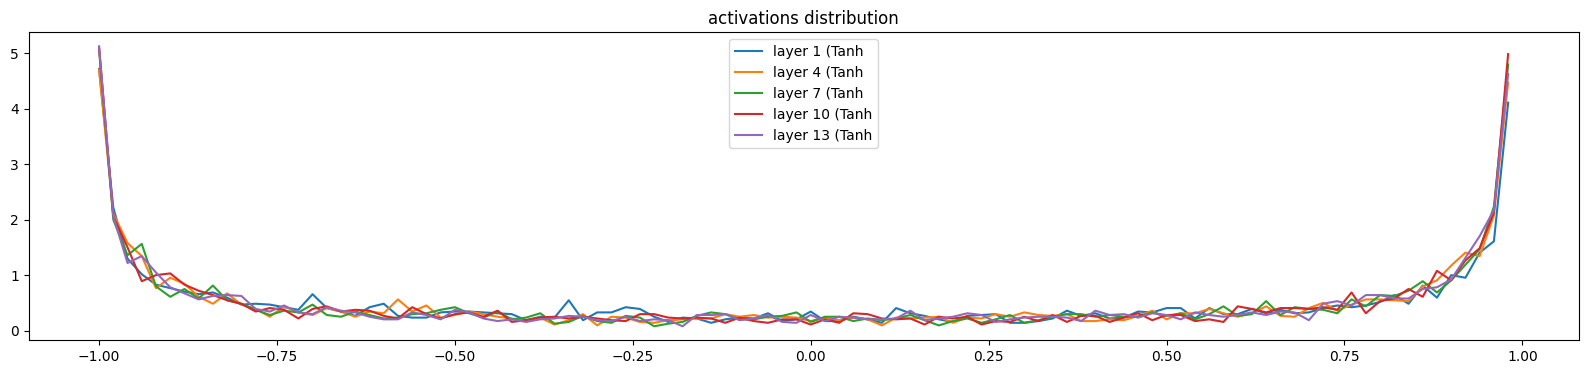

In [162]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")

plt.legend(legends)
plt.title("activations distribution");

layer 1 (      Tanh): mean -0.03, std 0.63, saturated: 4.44%
layer 4 (      Tanh): mean +0.00, std 0.68, saturated: 6.28%
layer 7 (      Tanh): mean -0.00, std 0.69, saturated: 8.31%
layer 10 (      Tanh): mean -0.01, std 0.70, saturated: 9.31%
layer 13 (      Tanh): mean +0.00, std 0.70, saturated: 8.25%


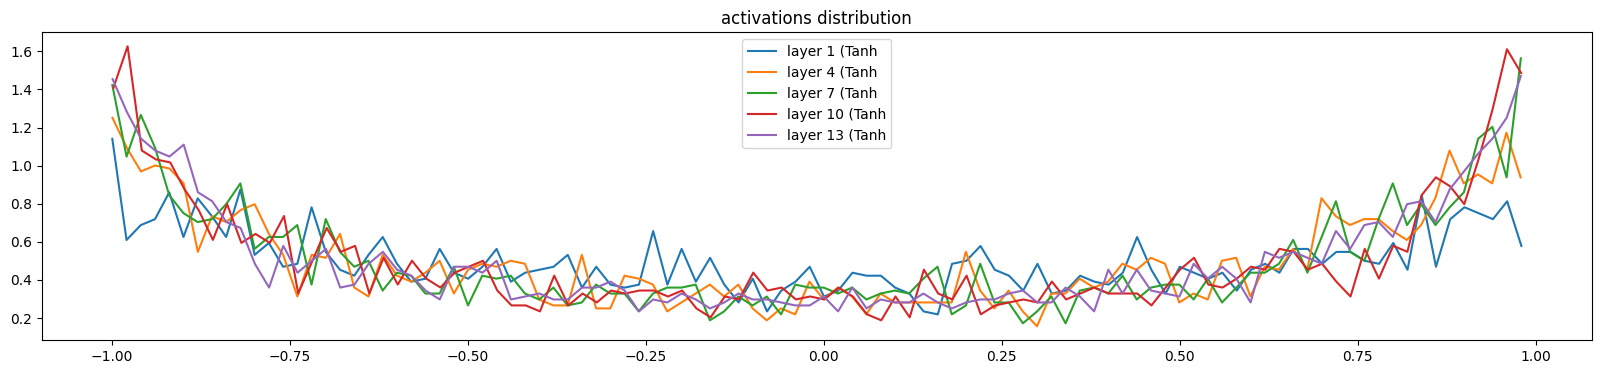

In [156]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")

plt.legend(legends)
plt.title("activations distribution");

layer 1 (      Tanh): mean +0.000000, std 2.788340e-03
layer 4 (      Tanh): mean +0.000000, std 2.110766e-03
layer 7 (      Tanh): mean -0.000000, std 1.997553e-03
layer 10 (      Tanh): mean +0.000000, std 1.902665e-03
layer 13 (      Tanh): mean -0.000000, std 1.865514e-03


Text(0.5, 1.0, 'gradient distribution')

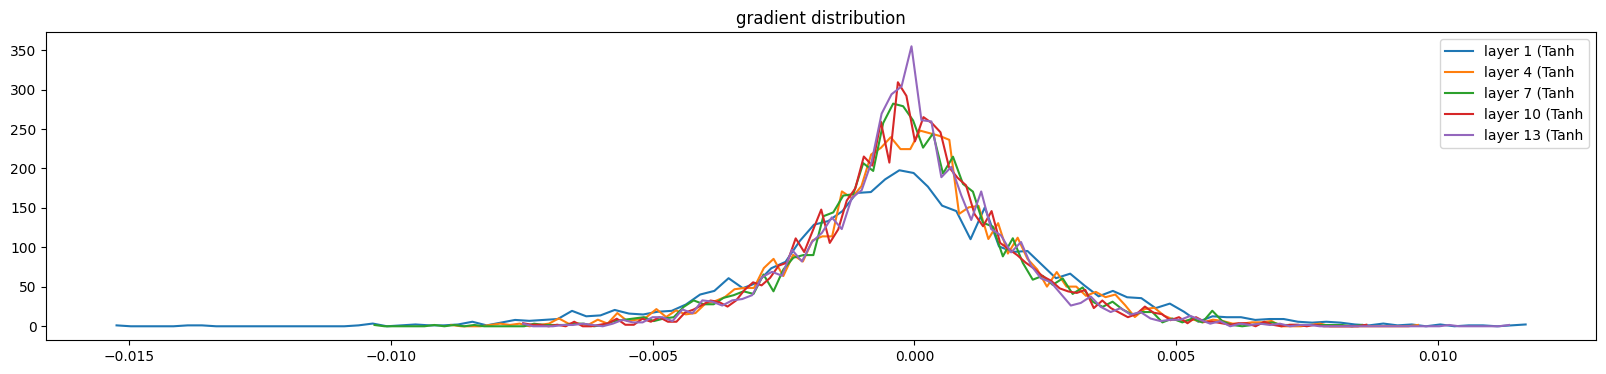

In [157]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000004 | std 7.202590e-03 | grad:data ratio 7.184513e-03
weight  (30, 100) | mean +0.000152 | std 9.967414e-03 | grad:data ratio 5.239095e-02
weight (100, 100) | mean -0.000110 | std 7.505309e-03 | grad:data ratio 7.273028e-02
weight (100, 100) | mean +0.000066 | std 6.883679e-03 | grad:data ratio 6.669332e-02
weight (100, 100) | mean +0.000032 | std 6.407501e-03 | grad:data ratio 6.255858e-02
weight (100, 100) | mean -0.000088 | std 5.557309e-03 | grad:data ratio 5.438177e-02
weight  (100, 27) | mean +0.000053 | std 1.139443e-02 | grad:data ratio 1.092933e-01


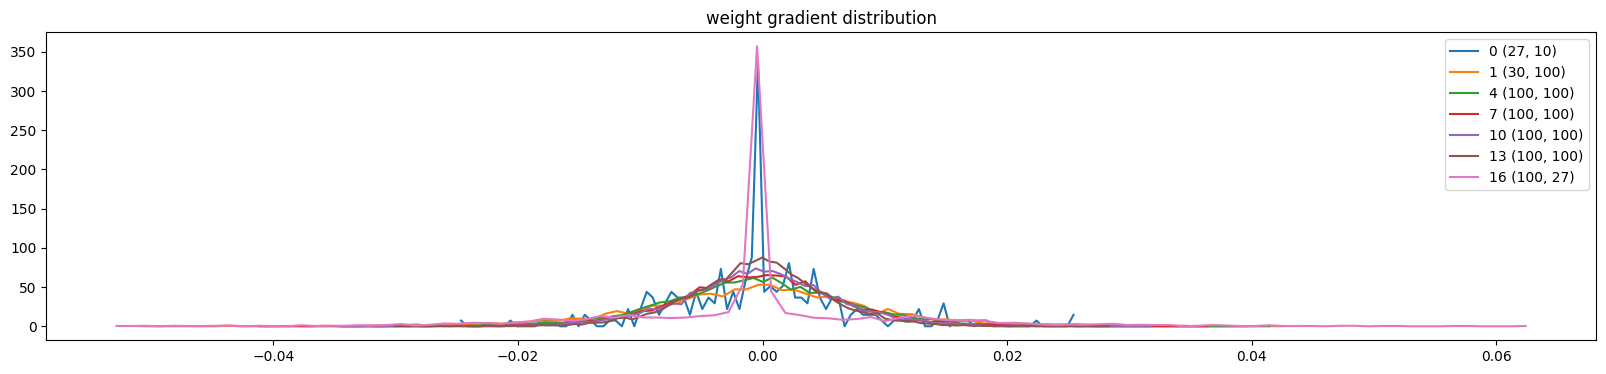

In [158]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        t = t.flatten()
        print("weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weight gradient distribution");


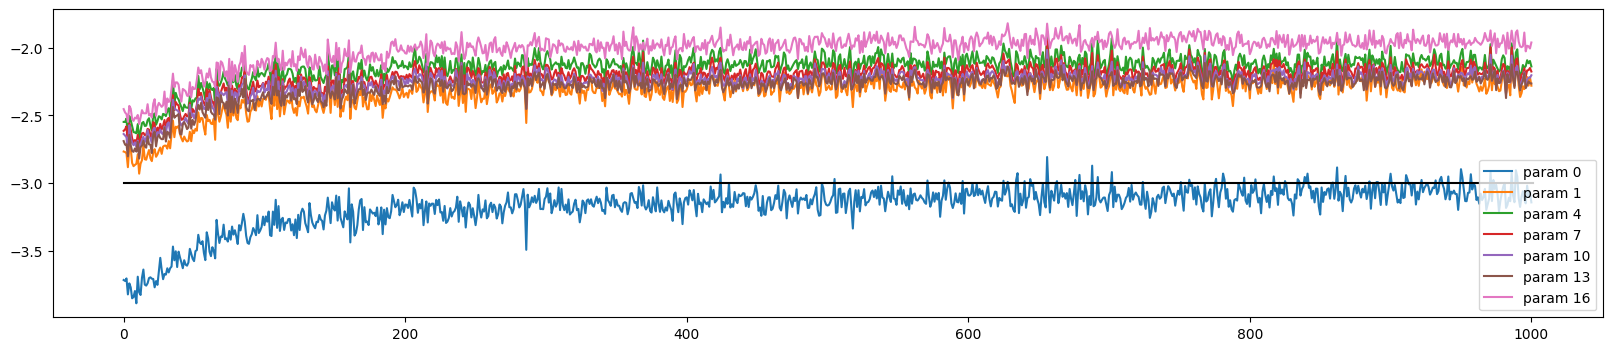

In [159]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)

In [205]:
class Module:
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError
    
    @property
    def parameters(self) -> List[Optional[torch.Tensor]]:
        raise NotImplementedError

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

class Embedding(Module):
    def __init__(self, vocab_size: int, emb_size: int) -> None:
        self._weight = torch.randn((vocab_size, emb_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        emb = self._weight[x]
        return emb.view(emb.shape[0], -1)

    @property
    def parameters(self) -> List[Optional[torch.Tensor]]:
        return [self._weight]

class Linear(Module):
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True, gain: float = 3/5) -> None:
        self._weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 * gain
        self._bias: Optional[torch.Tensor] = torch.randn(fan_out) if bias else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self._weight + (self._bias if self._bias is not None else 0)

    @property
    def parameters(self) -> List[Optional[torch.Tensor]]:
        return [self._weight, self._bias] if self._bias is not None else [self._weight]
    
class Tanh(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.tanh(x)

    @property
    def parameters(self) -> List[Optional[torch.Tensor]]:
        return []
    
class BatchNorm1d(Module):
    def __init__(self, fan_in: int, eps: float = 1e-5, momentum: float = 1e-1) -> None:
        self._gamma = torch.ones((1, fan_in))
        self._beta = torch.zeros((1, fan_in))

        self._momentum = momentum
        self._eps = eps

        self._training: bool = True
    
        self._mean_running = torch.zeros((1, fan_in))
        self._var_running = torch.ones((1, fan_in))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self._training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)

            with torch.no_grad():
                self._mean_running = self._mean_running * (1 - self._momentum) + xmean * self._momentum
                self._var_running = self._var_running * (1 - self._momentum) + xvar * self._momentum
        else:
            xmean = self._mean_running
            xvar = self._var_running
        
        xhat = (x - xmean) / torch.sqrt(xvar + self._eps)
        return xhat
    
    @property
    def parameters(self) -> List[Optional[torch.Tensor]]:
        return [self._gamma, self._beta]


class Sequential(Module):
    def __init__(self, *modules: Module) -> None:
        self._modules = modules
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for module in self._modules:
            x = module(x)
        return x
    
    @property
    def parameters(self) -> List[Optional[torch.Tensor]]:
        return [p for module in self._modules for p in module.parameters]

In [207]:
n_embd = 10
n_hidden = 200

network = Sequential(
    Embedding(vocab_size, n_embd),
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size, gain=0.1),
)

for p in network.parameters:
    p.requires_grad = True

In [213]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  out = network(Xb)
  loss = F.cross_entropy(out, Yb) # loss function
  
  for p in network.parameters:
    p.grad = None

  loss.backward()

  for p in network.parameters:
    print(p.grad)
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in network.parameters:
      p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

tensor([[-3.8133e-02, -1.3365e-02, -8.0774e-03,  1.1583e-02, -3.8666e-02,
         -4.9393e-02,  1.1597e-02, -5.1006e-03,  2.5480e-02, -1.1522e-02],
        [ 2.5779e-03, -1.8443e-02,  4.7653e-03, -8.3226e-05,  1.6607e-02,
          1.8679e-02,  1.1101e-02,  2.5816e-03, -2.1855e-02, -2.1759e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.5082e-03,  3.2605e-03,  1.0462e-02, -1.4266e-04,  4.1233e-03,
          9.2084e-03, -8.5110e-03,  1.7734e-03,  1.0359e-02, -6.5822e-04],
        [ 2.7722e-03,  1.4824e-02,  5.8578e-03,  2.1357e-02,  6.1056e-03,
          1.9062e-04, -5.7773e-03,  7.6308e-03, -1.7198e-03,  6.6849e-03],
        [ 4.0727e-03,  1.3086e-02, -2.3265e-03, -6.1596e-03,  1.5670e-02,
         -3.8918e-03,  5.5384e-03,  3.3119e-03,  6.6601e-04, -1.7697e-03],
        [-2.0091e-02, -1.3585e-02, -2.2548e-02,  3.0327e-02, -3.5465e-02,
         -4.3002e-02,  1.1342e-0

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'